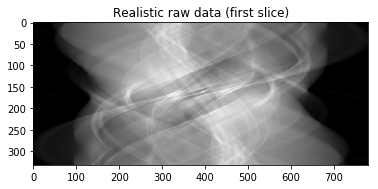

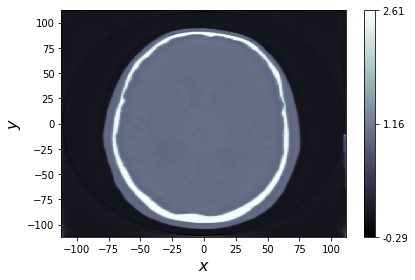

<Figure size 432x288 with 0 Axes>

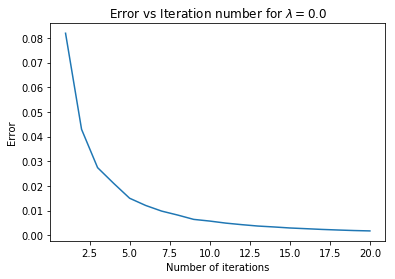

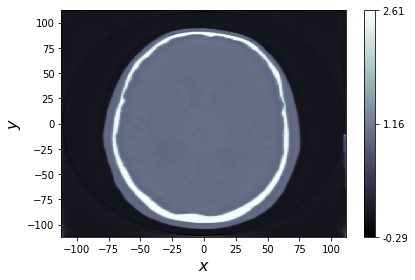

<Figure size 432x288 with 0 Axes>

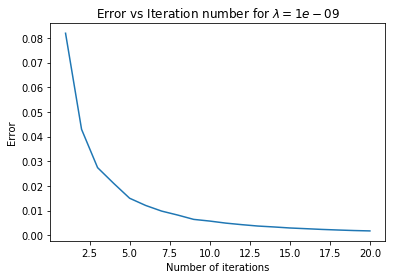

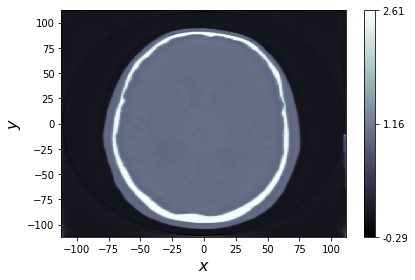

<Figure size 432x288 with 0 Axes>

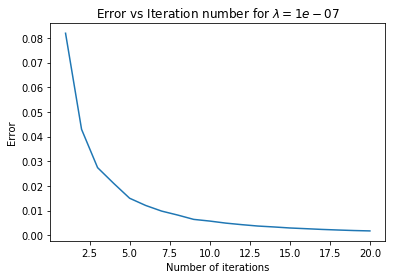

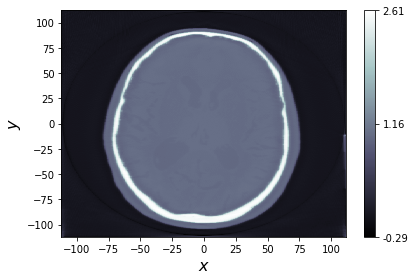

<Figure size 432x288 with 0 Axes>

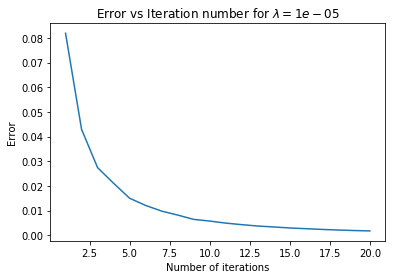

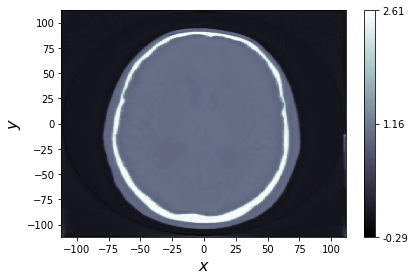

<Figure size 432x288 with 0 Axes>

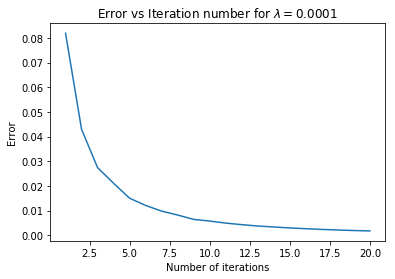

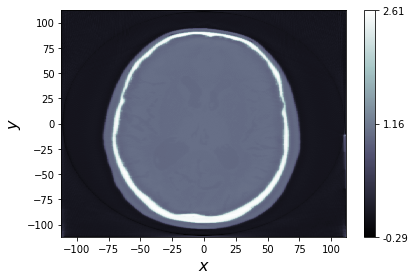

<Figure size 432x288 with 0 Axes>

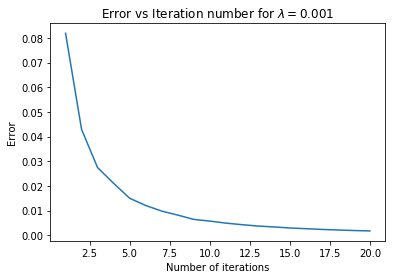

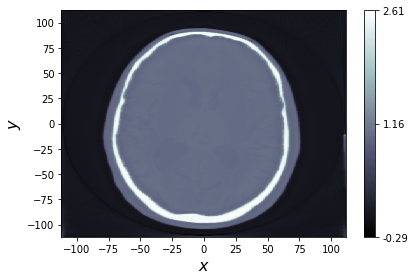

<Figure size 432x288 with 0 Axes>

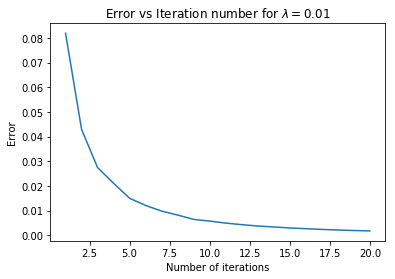

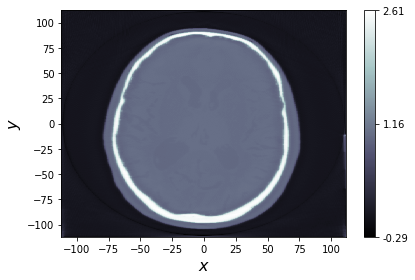

<Figure size 432x288 with 0 Axes>

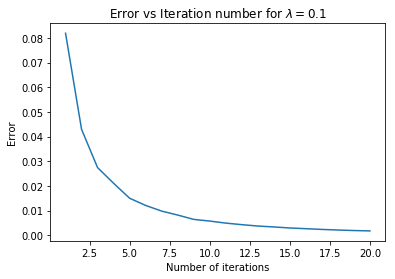

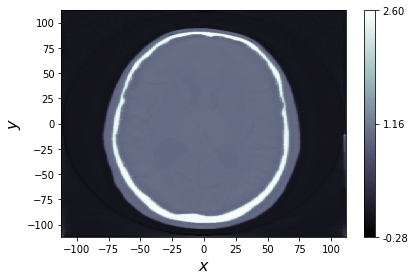

<Figure size 432x288 with 0 Axes>

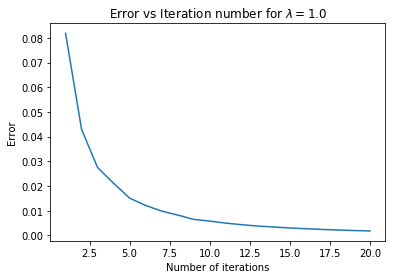

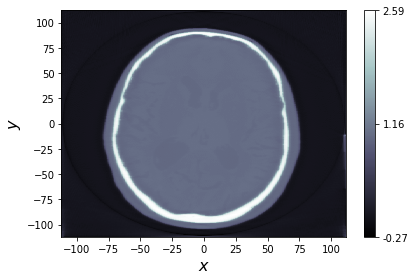

<Figure size 432x288 with 0 Axes>

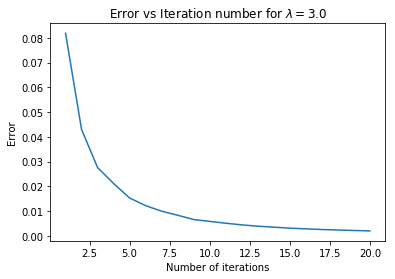

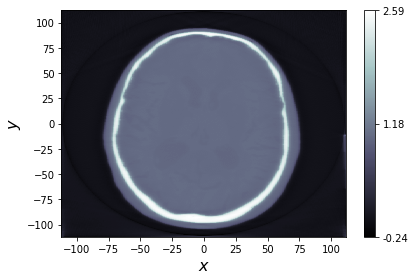

<Figure size 432x288 with 0 Axes>

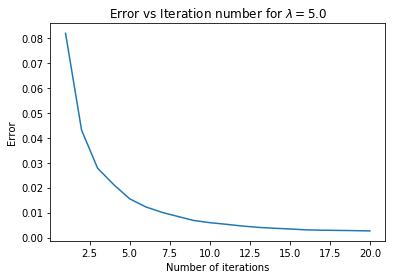

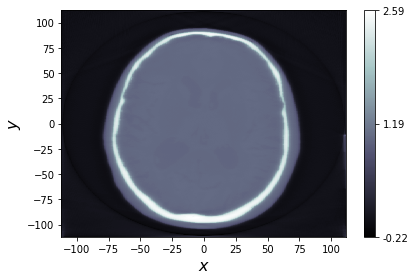

<Figure size 432x288 with 0 Axes>

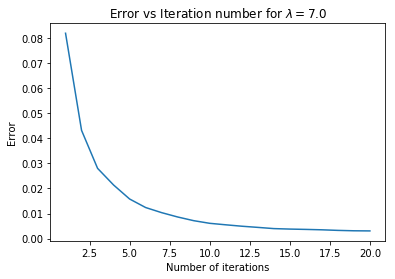

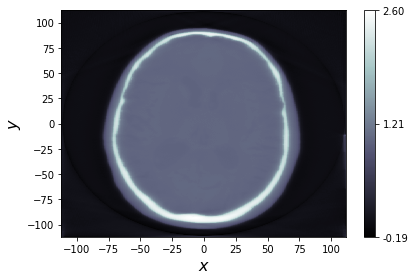

<Figure size 432x288 with 0 Axes>

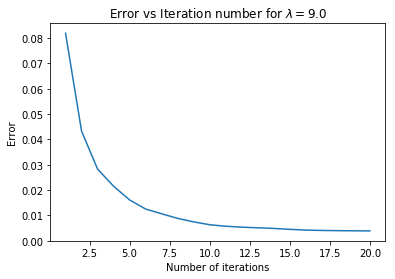

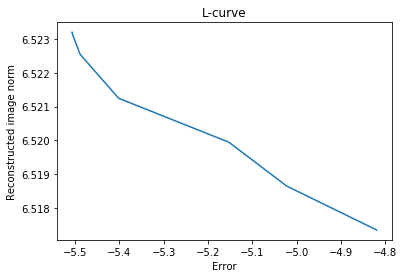

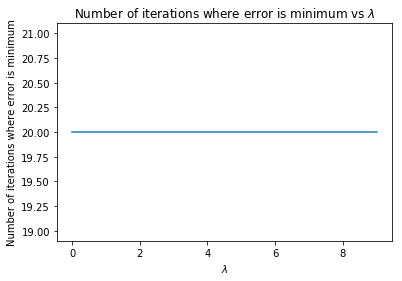

In [5]:
# Code for Miniproject 1
# Group 3: Andrés Martínez Mora & Sameer Manickam


import odl
import numpy as np
import matplotlib.pyplot as plt
import odl.contrib.tomo
from scipy.stats.distributions import norm

# Import all the useful modules for the project

# Obtain Ray Transform
# The geometry is already included in ODL.
geometry = odl.contrib.tomo.elekta_icon_geometry() # Geometry for realistic data
# The reconstruction space
reco_space = odl.uniform_discr([-112., -112., 0.],
                                [112., 112., 224.],
                                (448, 448, 448), dtype='float32')
#geometry=odl.tomo.geometry.parallel.parallel_beam_geometry(reco_space) # Geometry for phantom case
# With these data, we can compute the ray transform
# (which is the operator A in the text above).
# This operator can be applied to a reco_space.element()
# and returns a data_space.element().
ray_trafo = odl.tomo.RayTransform(reco_space, geometry)
# The data space is the range of the ray transform.
data_space = ray_trafo.range


y= np.load('/home/cpouchol/noisy_data.npy') # Load real data

# Image of the real data
plt.figure()
plt.title('Realistic raw data (first slice)')
plt.imshow(y[:,:,1],cmap='gray')



##########################################
# JUST ACTIVATE THESE LINES FOR THE PHANTOM CASE

# Define the phantom to work with
#phantom=odl.phantom.transmission.shepp_logan(reco_space,modified='True') 


# Obtain y for the problem. y is the sinogram
#y=ray_trafo(phantom)

#phantom.show()

#y.show()
# Add noise
#phantom=phantom+0.2*odl.phantom.noise.white_noise(reco_space) # Gaussian noise with mean zero and standard deviation=0.1
#y=ray_trafo(phantom) # Noisy sinogram

#phantom.show()
#y.show()
# x can be initially an image with the mean value of the phantom in all its voxels: JUST FOR THE PHANTOM
#phantom_array=np.asarray(phantom)
#avg=np.mean(np.ndarray.flatten(phantom_array))
#x=np.zeros(phantom.shape)+avg # Initialize the phantom with the mean value in all voxels
##########################################




# Obtain A transpose --> Backprojection
ray_trafo_t=odl.tomo.operators.ray_trafo.RayBackProjection(reco_space, geometry) # A transpose

# Implementation of regularized Conjugate Gradients Reconstruction
# Initialization parameters
# Measurement of some important errors for the code
l_error=[]
x_norm=[]
min_error=[]
# Reconstruction result initialization
#x=np.zeros(reco_space.shape) 
# Initialization of the number of iterations and the lambda values
iteration_num=20
lamda0=[0,10**(-9),10**(-7)]
lamda1=10**np.linspace(-5,0,6)
lamda2=np.linspace(3,9,4)
lamda1=list(lamda1)
lamda2=list(lamda2)
lamda=lamda0+lamda1+lamda2
lamda=np.asarray(lamda)







def conjugate_gradient_tikhonov(y,iteration_num,lamda,ray_trafo,ray_trafo_t,x):
    # Function for performing Conjugate Gradients with Tikhonov regularization. Inputs:
    # y: sinogram of raw data
    # iteration_num: number of iterations
    # lamda: vector with the lambda values to be tested
    # ray_trafo: forward operator (Ray Transform)
    # ray_trafo_t: transpose of forward operator (Backprojection operator)
    # x: initialization of the result to be reconstructed
    
    # As results, go plotting the final reconstruction after num_iter for all lambda combinations
    # Plot as well the L-curve for lambda optimization and the graph with the number of iterations providing the lowest residual
    
    # Lambda initialization
    for l in lamda: # Lambdas to work with
        x=np.zeros(reco_space.shape)
        x=reco_space.element(x)
        #print(np.asarray(ray_trafo_t(ray_trafo(x)-y)).shape)
        r=ray_trafo_t(ray_trafo(x)-y)+l*x # Initial guess for r
        #print(np.asarray(ray_trafo_t*(ray_trafo(x)-y)).shape)
        d=-r # Initial guess for d
        r1=data_space.element() # r for the next iteration
        beta=0 # Initial value for beta
        # Main core of the algorithm

        error=[]
        norm_iter=[]
        for k in range(iteration_num):
            t=-(data_space.inner(ray_trafo(d),(ray_trafo(x)-y))+l*reco_space.inner(x,d))/((ray_trafo(d).norm())**2+l*(d.norm())**2)
            # In the line above, t is computed
            x+=t*d # Next x computed (t is t(k+1) now, while d is d(k))
            r1=ray_trafo_t((ray_trafo(x)-y))+l*x # Next r to be computed
            beta=(r1.norm())**2/(r.norm())**2 # Beta for the computation of the next direction to follow in the algorithm
            d=-r1+beta*d # Computation of the next direction to follow in the algorithm
            x_array=np.asarray(x) # x transformed to numpy array
            x_aux=(x-np.min(np.ndarray.flatten(x_array)))/(np.max(np.ndarray.flatten(x_array))-np.min(np.ndarray.flatten(x_array)))
            # Normalized x between 0 and 1, so to compute the errors with respect to the original phantom                                                     
            err=((ray_trafo(x)-y).norm())/(y.shape[0]*y.shape[1]) # Residual error
            error.append(err) # List with the errors for all iterations                                                    
            r=r1
            norm_iter.append(x.norm()) # List with the norms of the results for all iterations

        x.show()
        # In case of the realistic dataset, display the middle coronal and sagittal slices
        #plt.figure()
        #plt.title('Middle sagittal slice reconstructed with '+str(iteration_num)+' iterations and ${\lambda}='+str(l)+'$')
        #plt.imshow(x[int(x.shape[0]/2),:,:],cmap='gray')
        
        #plt.figure()
        #plt.title('Middle coronal slice reconstructed with '+str(iteration_num)+' iterations and ${\lambda}='+str(l)+'$')
        #plt.imshow(x[:,int(x.shape[1]/2),:],cmap='gray')
        
        x_norm.append(min(norm_iter)) # Save reconstructed image norm for the minimum error so to later on plot L-curve
        if np.isnan(x.norm())==True:
            break
        l_error.append(min(error)) # Save error for the last iteration for each lambda so to later on plot L-curve
        ind_error=error.index(min(error))+1
        min_error.append(ind_error)
        # Plot with the errors vs the number of iterations
        plt.figure()
        plt.plot(np.linspace(1,iteration_num,iteration_num),error)
        plt.xlabel('Number of iterations')
        plt.ylabel('Error')
        plt.title('Error vs Iteration number for ${\lambda}='+str(l)+'$')  
        del x,r,d,r1,t,beta,x_array,x_aux,norm_iter # Delete variables from last lambda calculation so that they do not affect next lambda calculation
    



    # L-curve plotting
    plt.figure()
    plt.plot(np.log10(np.asarray(l_error)**2),np.log10(np.asarray(x_norm)**2))
    plt.xlabel('Error')
    plt.ylabel('Reconstructed image norm')
    plt.title('L-curve') 

    # Plot for the number of iterations with the minimum error vs lambda used
    plt.figure()
    plt.plot(lamda,min_error)
    plt.xlabel('${\lambda}$')
    plt.ylabel('Number of iterations where error is minimum')
    plt.title('Number of iterations where error is minimum vs ${\lambda}$')

    
    



# Main function call

x=conjugate_gradient_tikhonov(y,iteration_num,lamda,ray_trafo,ray_trafo_t,x)

[-3.12409378 -3.12409378 -3.12409378 -3.12409378 -3.12409378
 -3.12409257 -3.12408053 -3.12395891 -3.12253619 -3.11809546
 -3.11209084 -3.10480533 -3.09655141] [ 6.52319493  6.52319493  6.52319493  6.52319493  6.52319493
  6.52319435  6.52318844  6.52312982  6.52254388  6.52124319
  6.51994443  6.51864769  6.51735281]


Text(0.5, 1.0, 'L-curve')

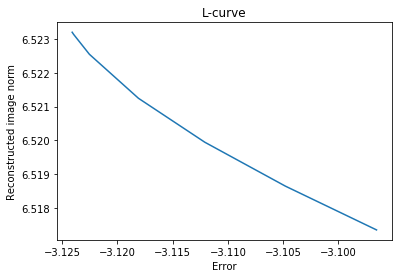

In [3]:
print(np.log10(np.asarray(l_error)**2),np.log10(np.asarray(x_norm)**2))




plt.figure()

plt.plot(np.log10(np.asarray(l_error)**2),np.log10(np.asarray(x_norm)**2))
plt.xlabel('Error')
plt.ylabel('Reconstructed image norm')
plt.title('L-curve') 

In [4]:
print(np.log10(np.asarray(l_error)**2),np.log10(np.asarray(x_norm)**2))

[-5.50647878 -5.50647878 -5.50647878 -5.50647871 -5.50647827
 -5.50647198 -5.50640798 -5.50564912 -5.4885856  -5.40164787
 -5.15289353 -5.02239831 -4.81984577] [ 6.52319493  6.52319493  6.52319493  6.52319493  6.52319493
  6.52319435  6.52318844  6.52312982  6.52254388  6.52124319
  6.51994443  6.51864769  6.51735281]


In [26]:
print(10**np.linspace(-5,1,7),1)

[  1.00000000e-05   1.00000000e-04   1.00000000e-03   1.00000000e-02
   1.00000000e-01   1.00000000e+00   1.00000000e+01] 1


In [6]:
print(phantom.shape)

(448, 448, 448)
